In [1]:
from docplex.mp.model import Model  #导出库，只用这一个就够了
import matplotlib.pyplot as plt#选取了用户47的365天的数据
import numpy as np
import pandas as pd
import csv
import cplex
from cplex.exceptions import CplexError
import time
import math
import openpyxl
from openpyxl import Workbook
import xlrd
import torch
from torch import nn
#from matplotlib.animation import FuncAnimation
#import matplotlib.animation as animation
import os
from collections import defaultdict
from random import uniform
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
import torch
#import torchvision
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
#print(torchvision.version) 
torch.cuda.current_device()
torch.cuda.get_device_name(0)

1.7.1
True
1


'NVIDIA GeForce GTX 1050'

In [2]:
#读取指定用户的数据：返回GG_array,Total_Load_array,pv_size
def Read_year(year,user):
    #read file, for example
    file_path = 'C:/Users/chenxihui/Desktop/code/project/'+str(year)+'.csv'
    file = open(file_path)
    data = []
    for i in file.readlines():
        data.append(i)
    file.close()
    new_data = []

    for row in data:
        tmp = row.strip('\n')  #去掉每行最后的回车符
        tmp = tmp.split(',')   #根据','来分割字符串，使之成为含有一个个数据的列表
        new_data.append(tmp)   #new_data的每一行数据就是一个列表
    select_data = []
    #position=[1,3,6,12,14,15,16,18,19,22,23,26,28,31,32,34,38,41,42,43,45,46,47]
    #这是在cluster里分类产生的结果，是人数最多的类，以此为对象
    users=['2','13','14','20','33','35','38','39','56','69','73','74','75'
          ,'82','87','88','101','104','106','109','110','119','124','130'
          ,'137','141','144','152','153','157','161','169','176','184','188'
          ,'189','193','201','202','204','206','207','210','211','212','214'
          ,'218','244','246','253','256','273','276','297']
    
    """
        user_chosen=[]
    for item in position:
        user_chosen.append(users[item])
    """
        
    length=len(new_data)
    for i in range(length):
        if(new_data[i][0]==users[user]):#这里的user指的是在54个里面的排序
            select_data.append(new_data[i][3:])#[5:]
            pv_size=float(new_data[i][1])
    GC=[]
    CL=[]
    GG=[]
    Length_select_data = len(select_data)
    for i in range(Length_select_data):
        if(select_data[i][0]=='GC'):
            GC.append(select_data[i][2:])
        elif(select_data[i][0]=='CL'):
            CL.append(select_data[i][2:])
        else:
            GG.append(select_data[i][2:])
            
    Total_Load=[]
    temp=[]
    a=0.0
    for i in range(Length_select_data):
        if(select_data[i][0]=='GC' and select_data[i+1][0]=='CL'):
            for j in range(len(select_data[i][2:])):
                a=pd.to_numeric(select_data[i][j+2])+pd.to_numeric(select_data[i+1][j+2])
                temp.append(a)
            Total_Load.append(temp)
        elif(select_data[i][0]=='GC' and select_data[i+1][0]!='CL'):
            Total_Load.append(select_data[i][2:])
        temp=[]
        
    GC_temp=np.array(GC)
    GC_array=[]
    GC_array = GC_temp.astype(np.float)*2

    GG_temp=np.array(GG)
    GG_array=[]
    GG_array = GG_temp.astype(np.float)*2#使单位变成了千瓦
    
    Total_Load_temp=np.array(Total_Load)
    Total_Load_array=[]
    Total_Load_array = Total_Load_temp.astype(np.float32)*2#一个小时的功率KW
    
    return GG_array,Total_Load_array,pv_size

In [3]:
##滚动法求24小时的最佳SOC，选取最前一段作为SOC，这里默认充放电功率界限和效率一样
def milp_one2(T_tou,T_fit,Total_Load_array,GG_array,bat_state,i,d,pb_bar,bat_max,efficiency_i,efficiency_c,dh,pg_bar):
    expression=0
    tfit=[]
    model = Model()####对变量命名并且给出上下界
    var_list = np.arange(0,48,1)
    X1 = model.continuous_var_list(var_list,lb=0.0,ub=pg_bar,name='X1')#代表pg_import(pg+)，功率
    X2 = model.continuous_var_list(var_list,lb=0.0,ub=pg_bar,name='X2')#代表pg_export(pg-)
    Y1 = model.continuous_var_list(var_list,lb=0.0,ub=pb_bar,name='Y1')#代表充电功率（pb+）
    Y2 = model.continuous_var_list(var_list,lb=0.0,ub=pb_bar,name='Y2')#代表放电功率（pb-）
    dg=model.binary_var_list(var_list,name='dg')#决策变量电网电力流向（0：用户到电网）
    sb=model.binary_var_list(var_list,name='sb')#决策变量电池充电状态（0：放电）
    eb=model.continuous_var_list(var_list,lb=0,name='eb')#电池容量SOC
    tou=[]
    tou.extend(T_tou[i:])
    tou.extend(T_tou[0:i])#输入分时电价
    
    for j in range(48):
        #tfit.append(T_fit)
        expression+=tou[j]*X1[j]*dh#X1为pg+,X2为pg-,Y1为pb+,Y2为pb-
        expression-=T_fit*X2[j]*dh
    #约束条件（2）
        if(j+i<48):#i表示第几个时刻
            model.add_constraint(X1[j]-X2[j]-efficiency_i*efficiency_c*Y1[j]+(efficiency_i/efficiency_c)*Y2[j]==
                         Total_Load_array[d][j+i]-efficiency_i*GG_array[d][j+i])
        else:
            model.add_constraint(X1[j]-X2[j]-efficiency_i*efficiency_c*Y1[j]+(efficiency_i/efficiency_c)*Y2[j]==
                         Total_Load_array[d+1][j+i-48]-efficiency_i*GG_array[d+1][j+i-48])
        
    #约束条件（3）
        bat_state.append(bat_state[-1]+dh*efficiency_c*Y1[j]-(dh/efficiency_c)*Y2[j])#约束条件（3）
        eb[j]=bat_state[-1]
        model.add_constraint(eb[j]<=bat_max)#约束条件（12）
        model.add_constraint(eb[j]>=0)#约束条件（12）
    #约束条件（4）
        model.add_constraint(X1[j]-pg_bar*dg[j]<=0)
    #约束条件（5）
        model.add_constraint(X2[j]+pg_bar*dg[j]<=pg_bar)
    #约束条件（6）
        model.add_constraint(Y1[j]-pb_bar*sb[j]<=0)
    #约束条件（7）
        model.add_constraint(Y2[j]+pb_bar*sb[j]<=pb_bar)
    model.minimize(expression)#目标函数    
    sol = model.solve() #输出解
    temp = sol.get_all_values()
    return temp,bat_state[0]

In [4]:
##对用户进行364天的SOC计算
def MILP_365(Total_Load_array,GG_array,user):
    L={0: 4,1: 5,2: 4,3: 4,4: 5,5: 5,6: 3,7: 3,8: 5,9: 5,10: 5,11: 8,12: 10,13: 7,14: 5,
 15: 5,16: 5,17: 4,18: 4,19: 10,20: 6,21: 5,22: 3,23: 4,24: 5,25: 6,26: 4,27: 9,28: 5,29: 10,
 30: 6,31: 5,32: 4,33: 3,34: 4,35: 5,36: 8,37: 5,38: 3,39: 4,40: 5,41: 6,42: 5,43: 4,
 44: 5,45: 4,46: 4,47: 5,48: 4,49: 6,50: 9,51: 7,52: 5,53: 4}
    #注意这里29和30是作者剔除的，这里考虑进来了
    days=364
    efficiency_i=0.9
    efficiency_c=0.95
    dh=0.5
    pg_bar=20
    T_flat=0.235018
    T_fit=0.09
    T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
    if(L[user]==3 or L[user]==4):
        init_state=6.5
        pb_bar=4.2
    elif(L[user]==5 or L[user]==6):
        init_state=9.8
        pb_bar=5
    elif(L[user] in [7,8,9,10]):
        init_state=14
        pb_bar=5
        
    bat_max=init_state
    bat_state=[0.5*init_state]#要输出的电池状态，这是0时刻的初始状态
    pg_import=[[] for _ in range(days)]
    pg_export=[[] for _ in range(days)]
    pb_c=[[] for _ in range(days)]
    pb_d=[[] for _ in range(days)]
    soc=[[] for _ in range(days)]
    soc[0]=[0.5*bat_max]
    
    for d in np.arange(0,days,1): 
        for i in range(48):
        #print(bat_state)
            temp=[]
            temp,before=milp_one2(T_tou,T_fit,Total_Load_array,GG_array,bat_state,i,d,pb_bar,bat_max,efficiency_i,efficiency_c,dh,pg_bar)
        #print(temp[96])
            if(i==47 and d<days-1):
                soc[d+1].append(abs(before+dh*efficiency_c*temp[96]-(dh/efficiency_c)*temp[144]))
            elif(i<47):     
                soc[d].append(abs(before+dh*efficiency_c*temp[96]-(dh/efficiency_c)*temp[144]))#bat_state保存的是滚动域内48个时刻都要满足电池约束，所以一个遍历完后得
        #重置，而SOC是要输出的值
            bat_state=[]
            bat_state.append(soc[d][-1])
        #d=bat_state[-1]+0.455*a[0]-(0.5/0.91)*a[0]
        #print(bat_state[-1])
            pg_import[d].append(abs(temp[0]))
            pg_export[d].append(abs(temp[48]))
            pb_c[d].append(abs(temp[96]))
            pb_d[d].append(abs(temp[144]))
    return soc,pg_import,pg_export,pb_c,pb_d

In [5]:
#将求出的一年的SOC值保存为excel格式，方便以后调用，节约时间
def save(data,path):
    wb = Workbook()
    ws = wb.active # 激活 worksheet
    [h, l] = np.array(data).shape  # h为行数，l为列数
    for i in range(h):
        row = []
        for j in range(l):
            row.append(format(data[i][j],'.4f'))
        ws.append(row)
    wb.save(path)

In [6]:
#读取之前保存的SOC值（excel形式的）
def read_data(road):
    workbook=openpyxl.load_workbook("C:/Users/chenxihui/Desktop/code/project/processed_data/2010/"+road+".xlsx")
    shenames=workbook.sheetnames
    worksheet=workbook.worksheets[0]
    name=worksheet.title 
    rows=worksheet.max_row
    columns=worksheet.max_column
    data_read=[[] for i in range(rows)]
    i=0
    for row in worksheet.rows:
        for cell in row:
            data_read[i].append(cell.value)
        i=i+1
    data_temp=np.array(data_read)
    data_array=[]
    data_array=data_temp.astype(np.float)
    return data_array

In [7]:
#为了训练RNN做的336维的数据集，大的数据集，包含了训练集和测试集
def samples(T_tou,soc_y,Total_Load_array,GG_array):
    #此版本为362天的样本数据点集合,从第一天开始算，但是第一天里都是空集合
    T_tou_temp=[]
    for i in range(3):
        T_tou_temp.extend(T_tou)
    days=365    
    data_365=[[[] for _ in range(48)] for _ in range(days)]
    for d in range(days):
        for i in range(48):
            data_temp=[]
            GG_temp=[]
            soc_temp=[]#前48个SOC（包含当前时刻）
            ToU_temp=[]
            load_temp=[]
            if(d<363 and d>0):
                if(i==47):
                    soc_temp=soc_y[d]
                    ToU_temp=np.hstack((T_tou,T_tou))
                    load_temp=np.hstack((Total_Load_array[d],Total_Load_array[d+1]))
                    GG_temp=np.hstack((GG_array[d],GG_array[d+1]))
                else:
                    soc_temp=np.hstack((soc_y[d-1][i+1:],soc_y[d][:i+1]))
                    ToU_temp=np.hstack((T_tou[i+1:],T_tou,T_tou[:i+1]))
                    GG_temp=np.hstack((GG_array[d-1][i+1:],GG_array[d],GG_array[d+1][:i+1]))#难道d+1是
                    load_temp=np.hstack((Total_Load_array[d-1][i+1:],Total_Load_array[d],Total_Load_array[d+1][:i+1]))
            data_temp=soc_temp
            data_temp=np.hstack((data_temp,ToU_temp))
            data_temp=np.hstack((data_temp,list(map(float, GG_temp))))
            data_temp=np.hstack((data_temp,load_temp))
            data_365[d][i]=data_temp
    return data_365

In [8]:
#生成训练RNN的训练集前300天
def generate_train(year,user):
    T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
    
    GG_array,Total_Load_array,pv_size=Read_year(year,user)
    soc_y=read_data("soc-"+str(user)+"-3")
    data_365=samples(T_tou,soc_y,Total_Load_array,GG_array)
    a=np.array(data_365[1:302]).transpose((1,0,2))#第二天
    soc_label=[[]for i in range(360)]
    for i in range(360):
        for j in np.arange(1,48):
            soc_label[i].append(soc_y[i+1][j])#因为label是下一时刻的SOC，所以从1开始
        soc_label[i].append(soc_y[i+2][0])
    return a,soc_label

In [9]:
### 此为300天-340天数据作为同一用户的测试集
def generate_test(year,user):
    T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
    GG_array,Total_Load_array,pv_size=Read_year(year,user)
    soc_y=read_data("soc-"+str(user)+"-3")
    data_365=samples(T_tou,soc_y,Total_Load_array,GG_array)
    
    test=np.array(data_365[302:342]).transpose((1,0,2))#测试集从第302天开始
    
    soc_label=[[]for i in range(360)]
    for i in range(360):
        for j in np.arange(1,48):
            soc_label[i].append(soc_y[i+1][j])
        soc_label[i].append(soc_y[i+2][0])
    return test,soc_label

In [10]:
### RNN的测试，对自己本身
def RNN_test(year,user,rnn,optimizer,N_EPOCHS,batch_nums,device,h_state,loss_func):    
    print("Testing...load model...")
    filepath = "./model/rnn"+str(year)+"-"+str(user)+".model"
    checkpoint = torch.load(filepath)
    rnn.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    rnn.eval()
    
    test,soc_label=generate_test(year,user)
    testloss=0
    with torch.no_grad():
        for step in range(40):
            test_x=torch.from_numpy(np.array(test[:,step,np.newaxis])).float().to(device)
            test_y = torch.from_numpy(np.array(soc_label[step+301])[:,np.newaxis,np.newaxis]).float().to(device)
            predict, h_state = rnn(test_x,h_state)
            loss_test = loss_func(predict, test_y)
            testloss+=loss_test
    print(str(user)+"testloss："+str(testloss))

In [40]:
#RNN网络的训练
def RNN_train(year,user,rnn,optimizer,N_EPOCHS,batch_nums,device,h_state,loss_func):
    rnn.train()
    a,soc_label = generate_train(year,user)
    train_loss=[]
    lr_list = []
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100,150,200,250,300], gamma=0.6)
    for step in range(N_EPOCHS):
        error=0.0
        for batch_num in range(batch_nums):#此处分成了
            x=torch.from_numpy(np.array(a[:,batch_num,np.newaxis])).float().to(device)
            y=torch.from_numpy(np.array(soc_label[batch_num])[:,np.newaxis,np.newaxis]).float().to(device)
            x=x.cuda()
            y=y.cuda()
            optimizer.zero_grad()#清零，模型的参数梯度设成0
            prediction, h_state = rnn(x, h_state)  # RNN输出（预测结果，隐藏状态）
            h_state = h_state.detach()  # 这一行很重要，将每一次输出的中间状态传递下去(不带梯度)，将h_state分离出来，同时不影响后向计算
            loss = loss_func(prediction, y)
            error += loss
            optimizer.zero_grad()#清零，模型的参数梯度设成0
            loss.backward()
            optimizer.step()
            scheduler.step()  # 学习率更新
            lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
            #torch.save(rnn.state_dict(), 'C:/Users/chenxihui/Desktop/code/project/rnn.pt')
        error /= batch_nums
        train_loss.append(error)
    print(str(user)+"  train Loss = " + str(error))#输出最后一个epoch输出的loss
    if not os.path.exists("./model/"):
        os.makedirs("./model/")
    filepath = "./model/rnn150"+str(year)+"-"+str(user)+".model"
    torch.save({"model_state_dict" : rnn.state_dict(),
            "optimizer_state_dict" : optimizer.state_dict()},
            filepath)   
    #print("Model has been saved.")
    #return train_loss[-1]

In [45]:
###step 4：对每个用户训练出的模型进行测试（在其他用户身上）
def model_test(year,user,rnn,optimizer,N_EPOCHS,batch_nums,device,h_state,loss_func,position):

    print("Testing...load model...")
    filepath = "./model/rnn150"+str(year)+"-"+str(user)+".model"
    checkpoint = torch.load(filepath)
    rnn.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    rnn.eval()
    testloss=0
    for num in position:
        test,soc_label=generate_test(2010,num)
        with torch.no_grad():
            for step in range(40):
                test_x=torch.from_numpy(np.array(test[:,step,np.newaxis])).float().to(device)
                test_y = torch.from_numpy(np.array(soc_label[step+301])[:,np.newaxis,np.newaxis]).float().to(device)
                predict, h_state = rnn(test_x,h_state)
                loss_test = loss_func(predict, test_y)
                testloss+=loss_test
    testloss=testloss/(40*len(position))
    print("Test has been done! The LOSS is: "+str(testloss))
    return testloss

In [13]:
start=time.time()
position1=[0, 4, 9, 10, 11, 21, 33, 35, 37, 49, 53]
get_indicator(position1)
#trainloss1=[1.7474,0.4365,8.6934,0.4851,0.5566,0.4812,1.5154,0.5805,0.5071,0.4809,1.2285]
end=time.time()
print("time: "+str(end-start))

NameError: name 'get_indicator' is not defined

In [74]:
start=time.time()
position2=[17, 51]
get_indicator(position2)
#trainloss=[0.1929,0.0488]
end=time.time()
print(end-start)

Testing...load model...
Test has been done! The LOSS is: tensor(0.1929, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.0488, device='cuda:0')
19.374608993530273


In [65]:
start=time.time()
position3=[13, 24, 25, 27, 29, 30, 44, 50, 52]
get_indicator(position3)
#trainloss3=[0.5221,0.1840,7.7851,15.6882,0.4583,0.5025,0.5215,0.3269,0.1678]
end=time.time()
print(end-start)

13  train Loss = tensor(0.5221, device='cuda:0', grad_fn=<DivBackward0>)
24  train Loss = tensor(0.1840, device='cuda:0', grad_fn=<DivBackward0>)
25  train Loss = tensor(7.7851, device='cuda:0', grad_fn=<DivBackward0>)
27  train Loss = tensor(15.6882, device='cuda:0', grad_fn=<DivBackward0>)
29  train Loss = tensor(0.4583, device='cuda:0', grad_fn=<DivBackward0>)
30  train Loss = tensor(0.5025, device='cuda:0', grad_fn=<DivBackward0>)
44  train Loss = tensor(0.5215, device='cuda:0', grad_fn=<DivBackward0>)
50  train Loss = tensor(0.3269, device='cuda:0', grad_fn=<DivBackward0>)
52  train Loss = tensor(0.1678, device='cuda:0', grad_fn=<DivBackward0>)
3293.621317625046


In [57]:
start=time.time()
position4=[1,3,6,12,14,15,16,18,19,22,23,26,28,31,32,34,38,41,42,43,45,46,47]
get_indicator(position4)
end=time.time()
trainloss=[0.0856,0.0458,0.0968,0.2776,0.0303,0.0289,0.0547,0.0628,0.3083,0.0690,
          0.0554,0.0272,0.0489,0.0357,0.0639,0.0418,0.1935,0.3638,0.1432,0.1196,0.1064,
          0.1629,0.0747]
print(end-start)

1  train Loss = tensor(0.0856, device='cuda:0', grad_fn=<DivBackward0>)
3  train Loss = tensor(0.0458, device='cuda:0', grad_fn=<DivBackward0>)
6  train Loss = tensor(0.0968, device='cuda:0', grad_fn=<DivBackward0>)
12  train Loss = tensor(0.2776, device='cuda:0', grad_fn=<DivBackward0>)
14  train Loss = tensor(0.0303, device='cuda:0', grad_fn=<DivBackward0>)
15  train Loss = tensor(0.0289, device='cuda:0', grad_fn=<DivBackward0>)
16  train Loss = tensor(0.0547, device='cuda:0', grad_fn=<DivBackward0>)
18  train Loss = tensor(0.0628, device='cuda:0', grad_fn=<DivBackward0>)
19  train Loss = tensor(0.3083, device='cuda:0', grad_fn=<DivBackward0>)
22  train Loss = tensor(0.0690, device='cuda:0', grad_fn=<DivBackward0>)
23  train Loss = tensor(0.0554, device='cuda:0', grad_fn=<DivBackward0>)
26  train Loss = tensor(0.0272, device='cuda:0', grad_fn=<DivBackward0>)
28  train Loss = tensor(0.0489, device='cuda:0', grad_fn=<DivBackward0>)
31  train Loss = tensor(0.0357, device='cuda:0', grad_

In [50]:
start=time.time()
position5=[2, 7, 20, 36, 39, 40, 48]#特征模型用户为36
indicator5=get_indicator(position5)
trainloss=[0.0810,0.2638,0.2189,0.3465,0.3312,9.0286,0.1605]
end=time.time()
print("time: "+str(end-start))

2  train Loss = tensor(0.0810, device='cuda:0', grad_fn=<DivBackward0>)
7  train Loss = tensor(0.2638, device='cuda:0', grad_fn=<DivBackward0>)
20  train Loss = tensor(0.2189, device='cuda:0', grad_fn=<DivBackward0>)
36  train Loss = tensor(0.3465, device='cuda:0', grad_fn=<DivBackward0>)
39  train Loss = tensor(0.3312, device='cuda:0', grad_fn=<DivBackward0>)
40  train Loss = tensor(9.0286, device='cuda:0', grad_fn=<DivBackward0>)
48  train Loss = tensor(0.1605, device='cuda:0', grad_fn=<DivBackward0>)
time: 2434.858733892441


In [90]:
start=time.time()
position1=[0, 4, 9, 10, 11, 21, 33, 35, 37, 49, 53]#特征模型用户为21
indicator1=get_indicator(position1)
print(indicator1)
l=[1.7474,0.4365,8.6934,0.4851,0.5566,0.4812,1.5154,0.5805,0.5071,0.4809,1.2285]
end=time.time()
print("time: "+str(end-start))

Testing...load model...
Test has been done! The LOSS is: tensor(1.7474, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.4365, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(8.6934, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.4851, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.5566, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.4812, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(1.5154, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.5805, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.5071, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.4809, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(1.2285, device='cuda:0')
4
time: 499.886361837

In [85]:
position2=[17, 51]#特征模型用户为51
indicator2=get_indicator(position2)
print(indicator2)
l=[2.2180,0.5608]

Testing...load model...
Test has been done! The LOSS is: tensor(2.2180, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.5608, device='cuda:0')
51


In [78]:
position3=[13, 24, 25, 27, 29, 30, 44, 50, 52]#特征模型用户为13
indicatoe3=get_indicator(position3)
l=[0.6137,1.3289,13.7423,13.2285,1.0719,1.1125,1.1355,0.6779,1.2856]

Testing...load model...
Test has been done! The LOSS is: tensor(0.6137, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(1.3289, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(13.7423, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(13.2285, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(1.0719, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(1.1125, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(1.1355, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.6779, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(1.2856, device='cuda:0')


In [74]:
position4=[1,3,6,12,14,15,16,18,19,22,23,26,28,31,32,34,38,41,42,43,45,46,47]
indicator4=get_indicator(position4)#特征模型用户为12
print(indicator4)
l=[0.3625,1.1782,0.9197,0.2516,0.3776,0.3634,0.4694,1.1811,0.2957,1.0435,
  0.9734,1.0916,0.3332,0.3766,1.0452,0.7833,1.0984,0.3818,0.3335,0.7830,0.9573,
  0.9487,0.3117]

Testing...load model...
Test has been done! The LOSS is: tensor(0.3625, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(1.1782, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.9197, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.2516, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.3776, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.3634, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.4694, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(1.1811, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.2957, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(1.0435, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.9734, device='cuda:0')
Testing...load model.

In [70]:
position5=[2, 7, 20, 36, 39, 40, 48]#特征模型用户为36
indicator5=get_indicator(position5)
print(indicator5)
l=[1.8237,1.9475,0.6829,0.5240,1.6702,9.7410,1.8307]

Testing...load model...
Test has been done! The LOSS is: tensor(1.8237, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(1.9475, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.6829, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(0.5240, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(1.6702, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(9.7410, device='cuda:0')
Testing...load model...
Test has been done! The LOSS is: tensor(1.8307, device='cuda:0')
36


In [47]:
position=[13]#特征模型用户为36
indicator=get_indicator(position)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/chenxihui/Desktop/code/project/processed_data/2010/soc-12-3.xlsx'

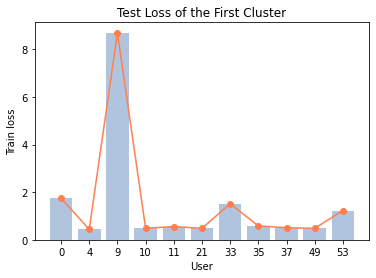

In [92]:
import matplotlib.pyplot as plt#选取了用户47的365天的数据
import numpy as np
import pandas as pd
import csv

position=[0, 4, 9, 10, 11, 21, 33, 35, 37, 49, 53]#特征模型用户为21
l=[1.7474,0.4365,8.6934,0.4851,0.5566,0.4812,1.5154,0.5805,0.5071,0.4809,1.2285]

plt.figure(1)
plt.bar(range(len(position)),l,color='lightsteelblue')
plt.plot(range(len(position)),l,marker='o',color='coral')
plt.xticks(range(len(position)),position)
plt.title(u'Test Loss of the First Cluster')
plt.xlabel(u'User')
plt.ylabel(u'Train loss')
plt.show()

In [46]:
#从类中返回该类的特征模型，position为一类
def get_indicator(position):
    ###超参数设置
    year=2010
    TIME_STEP = 48  # RNN时间步长
    INPUT_SIZE = 336  # RNN输入尺寸
    INIT_LR = 0.01  # 初始学习率
    N_EPOCHS = 150  # 训练回数
    Batch_size=1
    batch_nums=301
    train_loss,test_loss=[],[]
    ### RNN建立
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    class RNN(nn.Module):
        def __init__(self):
            super(RNN, self).__init__()
            self.rnn = nn.RNN(
                input_size=INPUT_SIZE,
                hidden_size=20,  # RNN隐藏神经元个数20
                num_layers=1,  # RNN隐藏层个数
            )
            self.out = nn.Linear(20, 1)#全连接层

        def forward(self, x, h):
            out, h = self.rnn(x, h)
            prediction = self.out(out)
            return prediction, h
    
    ###step 1：得到分类结果，给出属于同一类的用户标号
    #position=[1,3,6,12,14,15,16,18,19,22,23,26,28,31,32,34,38,41,42,43,45,46,47]
    scores=[]
    ###step 2：处理该类中MILP、SOC，为了节约时间，将他们先处理保存，之后读取即可
    #for user in position:
        #GG_array,Total_Load_array,pv_size=Read_year(year,user)
        #soc,pg_import,pg_export,pb_c,pb_d=MILP_365(Total_Load_array,GG_array,user)
    ###step 3：对每个用户训练一个模型
    for user in position:
        rnn = RNN().to(device)
        optimizer = torch.optim.Adam(rnn.parameters(), lr=INIT_LR)
        loss_func = nn.L1Loss()
        h_state = None #之前没有这个导致前一个用户的训练影响后一个用户了
        RNN_train(2010,user,rnn,optimizer,N_EPOCHS,batch_nums,device,h_state,loss_func)
        #RNN_test(2010,user,rnn,optimizer,N_EPOCHS,batch_nums,device,h_state,loss_func)
    ###step 4：对每个用户训练出的模型进行测试（在其他用户身上）
      
        #testloss=model_test(year,user,rnn,optimizer,N_EPOCHS,batch_nums,device,h_state,loss_func,position)
        #print(str(user)+" : "+str(testloss))
        #scores.append(testloss)
    ###step 5:选出类的特征模型
 #  minscore=2000
 #  for i in range(len(scores)):
 #      if(minscore>scores[i]):
 #          minscore=scores[i]
 #  for i in range(len(scores)):
 #      if(minscore==scores[i]):
 #          return position[i]#得到该类中的特征模型的用户编号


In [14]:
#生成聚类用的负载数据集
def cluster_allload(year):
    file_path = 'C:/Users/chenxihui/Desktop/code/project/'+str(year)+'.csv'
    file = open(file_path)
    data = []
    for i in file.readlines():
        data.append(i)
    file.close()
    new_data = []
    for row in data:
        tmp = row.strip('\n')  #去掉每行最后的回车符
        tmp = tmp.split(',')   #根据','来分割字符串，使之成为含有一个个数据的列表
        new_data.append(tmp)   #new_data的每一行数据就是一个列表
    select_data = []
    length=len(new_data)
    for i in range(length):
        if(new_data[i][0]=='2' or new_data[i][0]=='13' or new_data[i][0]=='14' or new_data[i][0]=='20' or new_data[i][0]=='33' or new_data[i][0]=='35' or new_data[i][0]=='38' or new_data[i][0]=='39' or new_data[i][0]=='56' or new_data[i][0]=='69' or new_data[i][0]=='73' or new_data[i][0]=='74' or new_data[i][0]=='75' or new_data[i][0]=='82' or new_data[i][0]=='87' or new_data[i][0]=='88' or new_data[i][0]=='101' or new_data[i][0]=='104' or new_data[i][0]=='106' or new_data[i][0]=='109' or new_data[i][0]=='110' or new_data[i][0]=='119' or new_data[i][0]=='124' or new_data[i][0]=='130' or new_data[i][0]=='137' or new_data[i][0]=='141' or new_data[i][0]=='144' or new_data[i][0]=='152' or new_data[i][0]=='153' or new_data[i][0]=='157' or new_data[i][0]=='161' or new_data[i][0]=='169' or new_data[i][0]=='176' or new_data[i][0]=='184' or new_data[i][0]=='188' or new_data[i][0]=='189' or new_data[i][0]=='193' or new_data[i][0]=='201' or new_data[i][0]=='202' or new_data[i][0]=='204' or new_data[i][0]=='206' or new_data[i][0]=='207' or new_data[i][0]=='210' or new_data[i][0]=='211' or new_data[i][0]=='212' or new_data[i][0]=='214' or new_data[i][0]=='218' or new_data[i][0]=='244' or new_data[i][0]=='246' or new_data[i][0]=='253' or new_data[i][0]=='256' or new_data[i][0]=='273' or new_data[i][0]=='276' or new_data[i][0]=='297'):
            select_data.append(new_data[i][3:])#[3:]
    GC=[]
    CL=[]
    GG=[]
    Length_select_data = len(select_data)
    for i in range(Length_select_data):
        if(select_data[i][0]=='GC'):
            GC.append(select_data[i][2:])
        elif(select_data[i][0]=='CL'):
            CL.append(select_data[i][2:])
        else:
            GG.append(select_data[i][2:])
    Total_Load=[]
    temp=[]
    Length_select_data = len(select_data)
    a=0.0
    for i in range(Length_select_data):
        if(select_data[i][0]=='GC' and select_data[i+1][0]=='CL'):
            for j in range(len(select_data[i][2:])):
                a=pd.to_numeric(select_data[i][j+2])+pd.to_numeric(select_data[i+1][j+2])
                temp.append(a)
            Total_Load.append(temp)
        elif(select_data[i][0]=='GC' and select_data[i+1][0]!='CL'):
            Total_Load.append(select_data[i][2:])
        temp=[]
    Total_Load_temp=np.array(Total_Load)
    Total_Load_array=[]
    Total_Load_array = Total_Load_temp.astype(np.float32)
    return Total_Load_array

In [15]:
#K-means方法
def generate_list():
    list = []
    return list

def point_avg(points):
    """
    Accepts a list of points, each with the same number of dimensions.
    NB. points can have more dimensions than 2
    
    Returns a new point which is the center of all the points.
    """
    dimensions = len(points[0])

    new_center = []

    for dimension in range(dimensions):
        dim_sum = 0  # dimension sum
        for p in points:
            dim_sum += p[dimension]

        # average of each dimension
        new_center.append(dim_sum / float(len(points)))

    return new_center


def update_centers(data_set, assignments):
    """
    Accepts a dataset and a list of assignments; the indexes 
    of both lists correspond to each other.
    Compute the center for each of the assigned groups.
    Return `k` centers where `k` is the number of unique assignments.
    """
    new_means = defaultdict(generate_list)
    centers = []
    for assignment, point in zip(assignments, data_set):
        new_means[assignment].append(point)
        
    for points in new_means.values():
        centers.append(point_avg(points))

    return centers


def assign_points(data_points, centers):
    """
    Given a data set and a list of points betweeen other points,
    assign each point to an index that corresponds to the index
    of the center point on it's proximity to that point. 
    Return a an array of indexes of centers that correspond to
    an index in the data set; that is, if there are N points
    in `data_set` the list we return will have N elements. Also
    If there are Y points in `centers` there will be Y unique
    possible values within the returned list.
    """
    assignments = []
    for point in data_points:
        shortest = (1000)  # positive infinity
        shortest_index = 0
        for i in range(len(centers)):
            val = distance(point, centers[i])
            if(val < shortest):
                shortest = val
                shortest_index = i
        assignments.append(shortest_index)
    return assignments


def distance(a, b):
    dimensions = len(a) 
    _sum = 0
    for dimension in range(dimensions):
        difference_sq = (a[dimension] - b[dimension]) ** 2
        _sum += difference_sq
    return sqrt(_sum)


def generate_k(data_set, k):
    centers = []
    dimensions = len(data_set[0])
    min_max = defaultdict(int)

    for point in data_set:
        for i in range(dimensions):
            val = point[i]
            min_key = 'min_%d' % i
            max_key = 'max_%d' % i
            if min_key not in min_max or val < min_max[min_key]:
                min_max[min_key] = val
            if max_key not in min_max or val > min_max[max_key]:
                min_max[max_key] = val

    for _k in range(k):
        rand_point = []
        for i in range(dimensions):
            min_val = min_max['min_%d' % i]
            max_val = min_max['max_%d' % i]
            
            rand_point.append(uniform(min_val, max_val))

        centers.append(rand_point)

    return centers


def k_means(dataset, k):
    k_points = generate_k(dataset, k)
    assignments = assign_points(dataset, k_points)
    old_assignments = None
    centers_history = []
    while assignments != old_assignments:
        new_centers = update_centers(dataset, assignments)
        centers_history.append(new_centers)
        old_assignments = assignments
        assignments = assign_points(dataset, new_centers)#centers_history[-1]

    return zip(assignments, dataset),centers_history[-1]

In [16]:
#返回对所有用户聚类的结果，以及类中心曲线
def cluster_result(year):
    Total_Load=cluster_allload(year)
    out,final_center = k_means(Total_Load, 5)
    list = []   # so, we need to show it in list
    for i in out:
        list.append(i)
    label_pred=[]
    points=[]
    length_list=len(list)
    for i in range(length_list):
        label_pred.append(list[i][0])
        points.append(list[i][1:])
    cluster_result=[i for i in range(54)]#i代表第几个用户
    for i in range(54):#因为一个用户有365天，选取365天中最多的类作为他的分类结果
        for j in np.arange(365*i,365*(i+1)):
            num=[0,0,0,0,0]
            if(label_pred[j]==0):
                num[0]+=1
            elif(label_pred[j]==1):
                num[1]+=1
            elif(label_pred[j]==2):
                num[2]+=1
            elif(label_pred[j]==3):
                num[3]+=1
            else:
                num[4]+=1
        if(max(num)==num[0]):
            cluster_result[i]=0
        elif(max(num)==num[1]):
            cluster_result[i]=1
        elif(max(num)==num[2]):
            cluster_result[i]=2
        elif(max(num)==num[3]):
            cluster_result[i]=3
        elif(max(num)==num[4]):
            cluster_result[i]=4
    finalnum=[0,0,0,0,0]
    position1,position2,position3,position4,position5=[],[],[],[],[]
    for j in range(54):
        if(cluster_result[j]==0):
            finalnum[0]+=1
        elif(cluster_result[j]==1):
            finalnum[1]+=1
        elif(cluster_result[j]==2):
            finalnum[2]+=1
        elif(cluster_result[j]==3):
            finalnum[3]+=1
        else:
            finalnum[4]+=1
    for j in range(54):
        if(cluster_result[j]==0):
            position1.append(j)
        elif(cluster_result[j]==1):
            position2.append(j)
        elif(cluster_result[j]==2):
            position3.append(j)
        elif(cluster_result[j]==3):
            position4.append(j)
        elif(cluster_result[j]==4):
            position5.append(j) 
    return final_center,position1,position2,position3,position4,position5

In [17]:
#生成新用户
def new_user(year,user):
    #read file, for example
    file_path = 'C:/Users/chenxihui/Desktop/code/project/'+str(year)+'.csv'
    file = open(file_path)
    data = []
    for i in file.readlines():
        data.append(i)
    file.close()
    new_data = []

    for row in data:
        tmp = row.strip('\n')  #去掉每行最后的回车符
        tmp = tmp.split(',')   #根据','来分割字符串，使之成为含有一个个数据的列表
        new_data.append(tmp)   #new_data的每一行数据就是一个列表
    select_data = []
    length=len(new_data)
    for i in range(length):
        if(new_data[i][0]==str(user)):#这里的user指的是在54个里面的排序
            select_data.append(new_data[i][3:])#[5:]
    GC=[]
    CL=[]
    GG=[]
    Length_select_data = len(select_data)
    print(Length_select_data)
    for i in range(Length_select_data):
        if(select_data[i][0]=='GC'):
            GC.append(select_data[i][2:])
        elif(select_data[i][0]=='CL'):
            CL.append(select_data[i][2:])
        else:
            GG.append(select_data[i][2:])
    #print(len(GC))
    #print(len(CL))
    #print(len(GG))
            
    Total_Load=[]
    temp=[]
    a=0.0
    for i in range(Length_select_data):
        if(select_data[i][0]=='GC' and select_data[i+1][0]=='CL'):
            for j in range(len(select_data[i][2:])):
                a=pd.to_numeric(select_data[i][j+2])+pd.to_numeric(select_data[i+1][j+2])
                temp.append(a)
            Total_Load.append(temp)
        elif(select_data[i][0]=='GC' and select_data[i+1][0]!='CL'):
            Total_Load.append(select_data[i][2:])
        temp=[]
    
    Total_Load_temp=np.array(Total_Load)
    Total_Load_array=[]
    Total_Load_array = Total_Load_temp.astype(np.float32)*2#功率
    
    return Total_Load_array[0:30]
#不妨将2010年用户为编号为2的前两个星期的数据为测试数据集
data_points=new_user(2010)

TypeError: new_user() missing 1 required positional argument: 'user'

In [31]:
#为节省时间，运行一遍后将数据保存直接用
final_center,position1,position2,position3,position4,position5=cluster_result(2010)

In [32]:
position1

[4, 5, 9, 10, 11, 13, 21, 24, 25, 27, 29, 33, 35, 49, 50, 52, 53]

In [33]:
position2

[17, 30, 51]

In [34]:
position3

[0,
 1,
 3,
 6,
 12,
 14,
 15,
 16,
 18,
 19,
 22,
 23,
 26,
 28,
 31,
 32,
 34,
 37,
 38,
 41,
 42,
 43,
 45,
 46,
 47]

In [35]:
position4

[2, 7, 8, 20, 36, 39, 40, 44, 48]

In [36]:
position5

[]

In [17]:
def SCM(load,GG,pb_bar,bat_max):
    bat_min,eff_i,eff_c,dh,pg_bar=0,0.9,0.95,0.5,np.max(load)
    pg_import,pg_export,pb_c,pb_d,pb_res,soc,e_b,eb_res,p_res=[],[],[],[],[],[],[0.5*bat_max],[],[]
    for d in np.arange(0,14,1):#天数设置
        for i in range(48):
            p_res.append(GG[d][i]*eff_i-load[d][i])
            #print(p_res[-1])
            #print(i)
            if(p_res[-1]>0.0):#发电量能满足需求的情况
                eb_res.append(bat_max-e_b[-1])
                #print(eb_res[-1])
                if(eb_res[-1]>0.0):#电池还能充电
                    #pb_c设置为pb_bar、p_res、将电池充满需要的电量中的最小值
                    pb_c.append(min(pb_bar,min(abs(p_res[-1])/(eff_i*eff_c),(eb_res[-1])/(dh*eff_c))))#此处改动原文eb_res[-1]/(dh*eff_c)
                    pg_export.append(abs(p_res[-1])-pb_c[-1]*eff_i*eff_c)#发电量满足充电后，卖电与eff_i有关
                    pb_d.append(0)#不放电
                    pg_import.append(0)#不用买电
                else:#电池满了，不能充电的情况
                    pg_export.append(abs(p_res[-1]))#直接卖电
                    pg_import.append(0)#不买电
                    pb_d.append(0)#不充电
                    pb_c.append(0)#不放电
            elif(p_res[-1]<0.0):#发电量不能满足需求的情况
                eb_res.append(e_b[-1]-bat_min)#电池可以放的电量
                #print(eb_res[-1])
                if(eb_res[-1]<0.01):#电池没电的情况
                    pg_import.append(abs(p_res[-1]))#买电，满足需求
                    pg_export.append(0)
                    pb_d.append(0)
                    pb_c.append(0)
                else:#电池有电的情况
                    pb_d.append(min(pb_bar,min(abs(p_res[-1])*eff_c/eff_i,(eb_res[-1]*eff_c)/(dh))))#放到电池外面的电
                    pb_c.append(0)
                    pg_import.append((abs(p_res[-1])-pb_d[-1]*eff_i/eff_c))#应该是买电，论文中的算法有错误
                    pg_export.append(0)
            else:
                pg_import.append(0.0)
                pg_export.append(0.0)
                pb_c.append(0.0)
                pb_d.append(0.0)
            e_b.append(e_b[-1]+dh*(eff_c*pb_c[-1]-pb_d[-1]/eff_c))
    return pg_import,pg_export,pb_c,pb_d,e_b

In [36]:
### RNN的测试，对自己本身
year=2010
TIME_STEP = 48  # RNN时间步长
INPUT_SIZE = 336  # RNN输入尺寸
INIT_LR = 0.01  # 初始学习率
N_EPOCHS = 300  # 训练回数
Batch_size=1
batch_nums=301
train_loss,test_loss=[],[]
    ### RNN建立
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=20,  # RNN隐藏神经元个数20
            num_layers=1,  # RNN隐藏层个数
            )
        self.out = nn.Linear(20, 1)#全连接层

    def forward(self, x, h):
        out, h = self.rnn(x, h)
        prediction = self.out(out)
        return prediction, h
    
rnn = RNN().to(device)
optimizer = torch.optim.Adam(rnn.parameters(), lr=INIT_LR)
loss_func = nn.MSELoss()
h_state = None 

def online(year,cluster_indicator,rnn,optimizer,N_EPOCHS,batch_nums,device,h_state,loss_func,point):    
    #print("Starting...")
    #print(point)
    filepath = "./model/rnn50"+str(year)+"-"+str(cluster_indicator)+".model"#这里读取的是类特征模型
    checkpoint = torch.load(filepath)
    rnn.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    rnn.eval()   #进入测试模式，权重不变
    #生成输入
    with torch.no_grad():
        #print(np.array(point[np.newaxis,np.newaxis,:]).shape)
        x=torch.from_numpy(np.array(point[np.newaxis,np.newaxis,:])).float().to(device)
        predict, h_state = rnn(x,h_state)
    return predict    

In [20]:
#在之前程序中已经确定了用户的几类
year=2010
position1=[0, 4, 9, 10, 11, 21, 33, 35, 37, 49, 53]#[0, 9, 10, 11, 21, 24, 33, 35, 37, 49, 53]
position2=[17, 51]
position3=[5, 8, 13, 24, 25, 27, 29, 30, 44, 50, 52]#[4, 5, 8, 13, 25, 27, 29, 30, 44, 50, 52]
position4=[1,3,6,12,14,15,16,18,19,22,23,26,28,31,32,34,38,41,42,43,45,46,47]
position5=[2, 7, 20, 36, 39, 40, 48]#[2, 7, 20, 36, 39, 40, 48]
#返回编号
indicators=[21,51,13,12,36]
#返回类中心特征曲线（由之前的训练的模型选出误差最小的）
center1=[0.4103962340079703,0.3175155649193957,0.30287106075935455,0.29468235979066965,
 0.28136126046933985,0.28048943129734466,0.2640939661165929,0.2623995003385951,
0.24764508070616315,0.2618234051773747,0.30250134526413336,0.34474346669713646,
 0.40536664109097237,0.5094425441318913,0.4663318599233165,0.4594996160898088,0.458490007657373,
 0.47407186793991657,0.4820770561144967,0.48134473480748086,0.4728660647029689,0.46123750960571747,
 0.4581362418010745,0.476272675277827,0.4987369328205739,0.4860128753993597,0.509019023876066,0.48793447328241774,
 0.4814508074134313,0.4734169867710797,0.4972138739861927,0.5235974248566684,
 0.5666356647639842,0.6369198692137866,0.7234202542644335,0.7849730976945295,0.8332959262134835,
 0.8107536514407793,0.774270753279546,0.7405336281724223,0.7616406610753849,
 0.6964231357937657,0.6633124518316299,0.6904235207405927,0.7791229825206302,
 0.9468793241284948,0.7377307836763091,0.5642966951739664]
center2=[0.7384689381469287,0.6514809635693659,0.5204549100668074,0.4373486990329319,
 0.35395791695522283,0.34255911756254626,0.3470781566295213,0.34281362773466084,
 0.310252504464321,0.30735671357485,0.45031663355135726,0.3954609209421522,
 0.4057134270354478,0.4718757518053891,0.5520280568425605,0.5704308601137332,0.6174689375968997,
 0.7202525068903136,0.839967935291942,0.8534969925387709,0.8995130248293132,0.9838597200557082,
 1.124547092598641,1.2737895792503215,1.4242625299893423,1.5805591188580215,1.6988456936194776,
 1.8265751481563868,1.9253807647045484,2.002080163520897,2.0732565148769018,2.1818957905731127,
 2.225174350152632,2.244366726455445,2.257993988289623,2.1907675340323745,2.0650921847992287,2.008072144327637,
 1.7419038100507789,1.5575330665816585,1.5610080209965695,1.410835673909388,1.304543087273866,
 1.1797555088399647,1.0231563138340662,0.9745210426932346,0.7634889787951399,0.7037294590267127]
center3=[0.6750413897335089,0.6356770138628643,0.5366984475032321,0.4449246123994798,0.38201034730554995,
 0.3251116036926861,0.31227050937508444,0.321696970234601,0.3485254992366784,0.3642609018449729,
 0.47088026640838987,0.5826895784845484,0.7424907613427262,1.3514028098585644,1.448623060323821,
 1.5446770149203952,1.4628152266868886,1.2163399847008216,0.9418832219569928,0.7994168517217646,
 0.7187620104887334,0.6407036219213463,0.5973636371008528,0.5966260164772371,0.6377538809881814,
 0.6319246118941949,0.5885920179147391,0.5750473025258347,0.5412771621772693,0.5277797488574179,
 0.6105173692432097,0.6339896512875184,0.7496097563447243,0.883702143220023,
 1.1373732460405284,1.38103621313727,1.4135291943793287,1.4201810794874905,1.3551714714707397,
 1.2983488543434047,1.3359815228650593,1.298035478333654,1.206448633176965,1.1074915004113561,0.9373614188071674,
 0.7663747228128617,0.5802209900219905,0.6052712492840275]
center4=[1.8038857808182172,1.8323606410241509, 1.608529137660226, 1.161272062561833, 0.7552933736983097,
 0.4778997669572676, 0.3584082585536477, 0.29380652695941384, 0.22956177187859306, 0.25116283731498484,
 0.4261485178568166, 0.3844405597294772, 0.4542094575420464, 0.5483106898445955, 0.4965930739569636,
 0.5394472189686753, 0.5030362967598986, 0.5022394271704541, 0.48106293752355317, 0.45518881130791133,
 0.42164102562895783, 0.3986460205317635, 0.38463802915841805, 0.3841058943014998, 0.38022710651015384,
 0.40910988975386997, 0.3920479520542539, 0.3832667331436734, 0.37643589705658026, 0.3838191809482523,
 0.3979370630342517, 0.419988345059551, 0.46426640015406845, 0.5516380284985145, 0.6713596401426242,
 0.7725151517216639, 0.7496090579593118, 0.6814538800838964, 0.5848434901586322,0.5557955382773271,
 0.5681991342478718, 0.5762174491569911, 0.550428904816285, 0.5093300035344316, 0.4941618386091608,
 0.4320396269779234, 0.5268877792831782, 1.2032953715903973]
center5=[0.23749103741076663, 0.18110123313631452, 0.16477442774983417, 0.15997813714737827, 0.14678199163625463,
 0.1329384521477881,0.12954605751684503, 0.13008258234678235, 0.13097523584037757, 0.14494052444248462,
 0.16393772680200938, 0.18616454261314813, 0.21695503069187932, 0.2302727178786652, 0.23206641806798398,
 0.23749621804973836, 0.2395027458650192, 0.23658854027227866, 0.22384281441001522, 0.216889027041851,
 0.21369702644617602, 0.21035488564611785, 0.21056937119911856, 0.21428307954688253, 0.21848958668001509,
 0.21211263099942967, 0.21206051205974774, 0.20945135220789163, 0.20769681914187876, 0.20823811009987908,
 0.2115407731127614, 0.22395741381088882, 0.24292954104971717, 0.2739028081497702, 0.32431292100120984,
 0.3549844575112232, 0.35232494038205164, 0.3486470832043504, 0.343012537651282, 0.34960770914559786,
 0.3646958863510122, 0.3462612164892822, 0.32825427411191466, 0.29978810499729414, 0.2912144857026353, 0.2804689669922541,
 0.2094759094312597, 0.2421168791074794]
final_center=[]
final_center.append(center1)
final_center.append(center2)
final_center.append(center3)
final_center.append(center4)
final_center.append(center5)
final_center
#给新用户进行分类
assignments=assign_points(data_points, final_center)
new_num=[0,0,0,0,0]
for i in range(len(assignments)):
    if(assignments[i]==0):
        new_num[0]+=1
    elif(assignments[i]==1):
        new_num[1]+=1
    elif(assignments[i]==2):
        new_num[2]+=1
    elif(assignments[i]==3):
        new_num[3]+=1
    elif(assignments[i]==4):
        new_num[4]+=1
maxnum=max(new_num)
for i in range(len(new_num)):
    if(maxnum==new_num[i]):
        newuser_cluster=i
print(newuser_cluster)

NameError: name 'data_points' is not defined

In [43]:
year=2010
#position3=[5, 8, 13, 24, 25, 27, 29, 30, 44, 50, 52]#[4, 5, 8, 13, 25, 27, 29, 30, 44, 50, 52]
#position4=[1,3,6,12,14,15,16,18,19,22,23,26,28,31,32,34,38,41,42,43,45,46,47]
#position2=[17, 51]
#position5=[2, 7, 20, 36, 39, 40, 48]
#position1=[0, 4, 9, 10, 11, 21, 33, 35, 37, 49, 53]
position1=[13]
cluster_indicator=13
cost1=[]
theta=[0,0.05,0.1]
T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
for user in position1:
    GG_array,Total_Load_array,pv_size=Read_year(year,user)
    for error in theta: 
        #soc_milp,pg_import,pg_export,pb_c_milp,pb_d_milp=MILP2(Total_Load_array,GG_array,user)
        pg_import,pg_export=PFA(year,user,cluster_indicator,GG_array,Total_Load_array,error)
        T_tou1=[]#PFA PP
        pg_import2,pg_export2,pb_c2,pb_d2=[],[],[],[]
        for i in np.arange(14,360,1):
            T_tou1.extend(T_tou)
            pg_import2.extend(pg_import[i])
            pg_export2.extend(pg_export[i])

        cost,dh,T_fit=0,0.5,0.09
        for i in range(len(pg_import2)):
            cost+=float(np.array(pg_import2[i]))*T_tou1[i]*dh-float(np.array(pg_export2[i]))*T_fit*dh
        print(str(user)+"  error:"+str(error)+"  cost: "+str(cost))
        #cost1.append(cost)

13  error:0  cost: 2856.405736268451
13  error:0.05  cost: 2856.4129239374065
13  error:0.1  cost: 2856.453591726858


In [26]:
theta=[0.025,0.05,0.1,0.3,0.5]
T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
user=21
GG_array,Total_Load_array,pv_size=Read_year(year,user)
for i in theta:
    soc_milp3,pg_import_milp3,pg_export_milp3,pb_c_milp3,pb_d_milp3=MILP2ip(Total_Load_array,GG_array,user,i)
    T_tou1=[]#PFA PP
    pg_import2,pg_export2,pb_c2,pb_d2=[],[],[],[]
    for i in np.arange(14,360,1):
        T_tou1.extend(T_tou)
        pg_import2.extend(pg_import_milp3[i])
        pg_export2.extend(pg_export_milp3[i])
    cost,dh,T_fit=0.0,0.5,0.09
    for i in range(len(pg_import2)):
        cost+=float(np.array(pg_import2[i]))*T_tou1[i]*dh-float(np.array(pg_export2[i]))*T_fit*dh
    print(str(user)+"cost: "+str(cost))

21cost: 1784.9955229599584
21cost: 1786.455710031883
21cost: 1785.4013080702887
21cost: 1785.4056960931835
21cost: 1787.3372241563052


In [56]:
cost1=[1759.546501710793,1418.4488748756376,2100.5816745398315,580.027326060818,
 230.03518096044735,1701.977674568222,1004.6668118992678,1017.8533949600451,
 939.2017553615267,1460.002264125957,1593.9369931556066]

[1759.546501710793,
 1418.4488748756376,
 2100.5816745398315,
 580.027326060818,
 230.03518096044735,
 1701.977674568222,
 1004.6668118992678,
 1017.8533949600451,
 939.2017553615267,
 1460.002264125957,
 1593.9369931556066]

In [54]:
cost5=[475.6282421084642,1721.4524450001873,498.9156382740928,1182.1797473858144,
 1697.7798108680756,2113.1196233249507,2007.2593495788942]

[475.6282421084642,
 1721.4524450001873,
 498.9156382740928,
 1182.1797473858144,
 1697.7798108680756,
 2113.1196233249507,
 2007.2593495788942]

In [51]:
cost2=[2727.884288516861, 146.37710982385786]

[2727.884288516861, 146.37710982385786]

In [52]:
cost4=[355.9557446170069,381.561069401228,1003.0000154395157,402.3556608808183,
 161.03452063065615,284.58802534438,418.7148237368523,724.8510623623731,974.8340885480274,
 765.1350290560753,759.6755034304091,446.5041170470754,218.80243797828737,156.7408698209828,
 401.2873620354249,433.47551941668127,1123.8383433061174,1477.3401115669049,767.175682105638,
 887.7325503398644,805.7421188498471,1417.2765382091454,622.808309071249]

In [47]:
cost3=[2250.299205312047, 2312.258896497063,1912.2763698200522,1006.745362727728,
 2214.2315937108947,1319.6256179779623,-257.1980509282767,2075.498122460309,
 2127.2642496685803,1213.910315363987,1331.8240139933885]

[2250.299205312047,
 2312.258896497063,
 1912.2763698200522,
 1006.745362727728,
 2214.2315937108947,
 1319.6256179779623,
 -257.1980509282767,
 2075.498122460309,
 2127.2642496685803,
 1213.910315363987,
 1331.8240139933885]

In [19]:
#分完类后对用户执行线上执行策略，执行前得做输入数据集
    #cluster_indicator=indicators[newuser_cluster]
def PFA(year,user,cluster_indicator,GG_array,Total_Load_array,theta):
    #cluster_indicator=indicators[newuser_cluster]
    #user=cluster_indicator  # 13，"82"
    #GG_array,Total_Load_array,pv_size=Read_year(year,user)#USER[13]=82
    #soc_milp,pg_import_milp,pg_export_milp,pb_c_milp,pb_d_milp=MILP2(Total_Load_array,GG_array,user)
    T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
           0.38588,0.38588, 0.38588,0.38588, 
          0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
          0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
          0.37147,0.37147,0.37147,0.37147,
          0.2134,0.2134,0.2134,0.2134]
    days=365
    eff_i,eff_c,dh,bat_min,T_flat,T_fit=0.9,0.95,0.5,0,0.235018,0.09
    points365=[[[] for _ in range(48)] for _ in range(days)]
    pg_import=[[0 for i in range(48)] for _ in range(days)]
    pg_export=[[0 for i in range(48)] for _ in range(days)]
    pb_c=[[0 for i in range(48)] for _ in range(days)]
    pb_d=[[0 for i in range(48)] for _ in range(days)]
    L={0: 4,1: 5,2: 4,3: 4,4: 5,5: 5,6: 3,7: 3,8: 5,9: 5,10: 5,11: 8,12: 10,13: 7,14: 5,
                 15: 5,16: 5,17: 4,18: 4,19: 10,20: 6,21: 5,22: 3,23: 4,24: 5,25: 6,26: 4,27: 9,28: 5,29: 10,
                 30: 6,31: 5,32: 4,33: 3,34: 4,35: 5,36: 8,37: 5,38: 3,39: 4,40: 5,41: 6,42: 5,43: 4,
                 44: 5,45: 4,46: 4,47: 5,48: 4,49: 6,50: 9,51: 7,52: 5,53: 4}
    pg_bar=20
    if(L[user]==3 or L[user]==4):
        init_state=6.5
        pb_bar=4.2
    elif(L[user]==5 or L[user]==6):
        init_state=9.8
        pb_bar=5
    elif(L[user] in [7,8,9,10]):
        init_state=14
        pb_bar=5
    bat_max=init_state
    bat_min=0
    pgi_scm,pgo_scm,pb_cscm,pb_dscm,e_bscm=SCM(Total_Load_array,GG_array,pb_bar,bat_max)
    pred=[e_bscm[672]]#0
    soc_init=e_bscm[624:672]
    for d in np.arange(14,360,1):#360
        for i in range(48):#要做出决策的时段
    #从用户第三个星期开始运行
    #制作线上执行模型的第一个点336维,第15天的0:30
            data_temp,GG_temp,soc_temp,ToU_temp,load_temp=[],[],[],[],[]#前48个SOC（包含当前时刻）
            for j in range(47):
                soc_init[j]=soc_init[j+1]
            soc_init[-1]=pred[-1]#SOC更新
            if(i==0):
                ToU_temp=np.hstack((T_tou,T_tou))
                GG_temp=np.hstack((GG_array[d-1],[i+np.random.uniform(-theta*i, theta*i) for i in GG_array[d]]))
                load_temp=np.hstack((Total_Load_array[d-1],[j+np.random.uniform(-theta*j, theta*j) for j in Total_Load_array[d]]))
            else:
                ToU_temp=np.hstack((T_tou[i:],T_tou,T_tou[:i]))
                GG_temp=np.hstack((GG_array[d-1][i:],GG_array[d],GG_array[d+1][:i]))#难道d+1是
                for j in np.arange(48,96,1):
                    GG_temp[j]=GG_temp[j]+np.random.uniform(-theta*GG_temp[j], theta*GG_temp[j])#*GG_temp[j]
                load_temp=np.hstack((Total_Load_array[d-1][i:],Total_Load_array[d][:i],
                                     [j+np.random.uniform(-theta*j, theta*j) for j in Total_Load_array[d][i:]],
                                     [j+np.random.uniform(-theta*j, theta*j) for j in Total_Load_array[d+1][:i]]))
            data_temp=soc_init
            data_temp=np.hstack((data_temp,ToU_temp))
            data_temp=np.hstack((data_temp,list(map(float, GG_temp))))
            data_temp=np.hstack((data_temp,load_temp))
            points365[d][i]=data_temp
    #返回线上执行预测的
            predict=online(year,cluster_indicator,rnn,optimizer,N_EPOCHS,batch_nums,device,h_state,loss_func,points365[d][i]).item()
            #print(predict)
            soc_before=pred[-1]
            if(predict>bat_max or abs(predict-soc_before)>pb_bar):#预测结果有风险的情况
                Total_Load_array,GG_array,pg_import,pg_export,pb_c,pb_d,pred=SCM2(Total_Load_array,GG_array,pg_import,pg_export,pb_c,pb_d,pb_bar,bat_max,bat_min,eff_i,eff_c,dh,pg_bar,pred,d,i,theta)
            else:#预测结果没问题的情况
                pg_import,pg_export,pb_c,pb_d,GG_array,Total_Load_array=update(predict,GG_temp,load_temp,user,GG_array,Total_Load_array,d,i,pred
                  ,pg_import,pg_export,pb_c,pb_d,bat_max,eff_i,eff_c,dh,theta)
                pred.append(predict)
    return pg_import,pg_export

In [38]:
##对用户进行364天的SOC计算
def MILP2(Total_Load_array,GG_array,user):
    L={0: 4,1: 5,2: 4,3: 4,4: 5,5: 5,6: 3,7: 3,8: 5,9: 5,10: 5,11: 8,12: 10,13: 7,14: 5,
 15: 5,16: 5,17: 4,18: 4,19: 10,20: 6,21: 5,22: 3,23: 4,24: 5,25: 6,26: 4,27: 9,28: 5,29: 10,
 30: 6,31: 5,32: 4,33: 3,34: 4,35: 5,36: 8,37: 5,38: 3,39: 4,40: 5,41: 6,42: 5,43: 4,
 44: 5,45: 4,46: 4,47: 5,48: 4,49: 6,50: 9,51: 7,52: 5,53: 4}
    #注意这里29和30是作者剔除的，这里考虑进来了
    
    days=364
    efficiency_i=0.9
    efficiency_c=0.95
    dh=0.5
    pg_bar=20
    T_flat=0.235018
    T_fit=0.09
    T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
    if(L[user]==3 or L[user]==4):
        init_state=6.5
        pb_bar=4.2
    elif(L[user]==5 or L[user]==6):
        init_state=9.8
        pb_bar=5
    elif(L[user] in [7,8,9,10]):
        init_state=14
        pb_bar=5
        
    bat_max=init_state
    #bat_state=[0.5*init_state]#要输出的电池状态，这是0时刻的初始状态
    bat_state=[0]
    pg_import=[[0 for i in range(48)] for _ in range(days)]
    pg_export=[[0 for i in range(48)] for _ in range(days)]
    pb_c=[[0 for i in range(48)] for _ in range(days)]
    pb_d=[[0 for i in range(48)] for _ in range(days)]
    soc=[]#电池状态用一维数组接收
    #soc[0]=[0.5*bat_max]
    soc.append(0)#0是初试的
    
    for d in np.arange(14,360,1): 
        for i in range(48):
        #print(bat_state)
            temp=[]
            temp,before=milp_one2(T_tou,T_fit,Total_Load_array,GG_array,bat_state,i,d,pb_bar,bat_max,efficiency_i,efficiency_c,dh,pg_bar)
        #print(temp[96])
            soc.append(before+dh*efficiency_c*temp[96]-(dh/efficiency_c)*temp[144])#bat_state保存的是滚动域内48个时刻都要满足电池约束，所以一个遍历完后得
        #重置，而SOC是要输出的值
            bat_state=[]
            bat_state.append(soc[-1])
        #d=bat_state[-1]+0.455*a[0]-(0.5/0.91)*a[0]
        #print(bat_state[-1])
            pg_import[d][i]=(abs(temp[0]))
            pg_export[d][i]=(abs(temp[48]))
            pb_c[d][i]=(abs(temp[96]))
            pb_d[d][i]=(abs(temp[144]))
    return soc,pg_import,pg_export,pb_c,pb_d

def SCM2(load,GG,pg_import,pg_export,pb_c,pb_d,pb_bar,bat_max,bat_min,eff_i,eff_c,dh,pg_bar,pred,d,i,theta):
    GG[d][i]=GG[d][i]+np.random.uniform(-theta*GG[d][i], theta*GG[d][i])
    load[d][i]=load[d-7][i]
    p_res=GG[d][i]*eff_i-load[d][i]
    if(p_res>0.0):#发电量能满足需求的情况
        eb_res=bat_max-pred[-1]
        if(eb_res>0.0):#电池还能充电
            #pb_c设置为pb_bar、p_res、将电池充满需要的电量中的最小值
            pb_c[d][i]=min(pb_bar,min(abs(p_res)*eff_i,(eb_res)/(dh*eff_c)))#此处改动原文eb_res[-1]/(dh*eff_c)
            pg_export[d][i]=abs(p_res)-pb_c[d][i]/eff_i#发电量满足充电后，卖电与eff_i有关
            pb_d[d][i]=(0)#不放电
            pg_import[d][i]=(0)#不用买电
        else:#电池满了，不能充电的情况
            pg_export[d][i]=(abs(p_res))#直接卖电
            pg_import[d][i]=(0)#不买电
            pb_d[d][i]=(0)#不充电
            pb_c[d][i]=(0)#不放电
    elif(p_res<0.0):#发电量不能满足需求的情况
        eb_res=(pred[-1]-bat_min)#电池可以放的电量
        if(eb_res<0.01):#电池没电的情况
            pg_import[d][i]=(abs(p_res))#买电，满足需求
            pg_export[d][i]=(0)
            pb_d[d][i]=(0)
            pb_c[d][i]=(0)
        else:#电池有电的情况
            pb_d[d][i]=(min(pb_bar,min(abs(p_res)/eff_i,(eb_res*eff_c)/(dh))))#放到电池外面的电
            pb_c[d][i]=(0)
            pg_import[d][i]=((abs(p_res)-pb_d[d][i]*eff_i))#应该是买电，论文中的算法有错误
            pg_export[d][i]=(0)
    else:
        pg_import[d][i]=(0.0)
        pg_export[d][i]=(0.0)
        pb_c[d][i]=(0.0)
        pb_d[d][i]=(0.0)
    pred.append(pred[-1]+dh*(eff_c*pb_c[d][i]-pb_d[d][i]/eff_c))
    return load,GG,pg_import,pg_export,pb_c,pb_d,pred

def update(predict,ggtemp,loadtemp,user,GG_array,Total_Load_array,d,i,pred,
           pg_import,pg_export,pb_c,pb_d,bat_max,eff_i,eff_c,dh,theta):
############电池单位为千瓦时，其他都是以千瓦为单位####
    soc_before=pred[-1]
    theta1=(predict-soc_before)
    #GG_array[d][i]=GG_array[d][i]+np.random.uniform(-theta*GG_array[d][i], theta*GG_array[d][i])
    #Total_Load_array[d][i]=Total_Load_array[d-7][i]
    if(theta1>=0.0):#要充电
        pb_c[d][i]=(theta1)/(dh*eff_c)
        pb_d[d][i]=(0)
        theta2=GG_array[d][i]*eff_i-Total_Load_array[d][i]-pb_c[d][i]*eff_c*eff_i#下一时刻实际发电量是否满足
        
        if(theta2>=0):#发电量够了,卖电
            pg_import[d][i]=0
            pg_export[d][i]=(theta2)#卖出多余的电
        else:#thata3<0，剩余发电量不能满足负载，买电
            pg_import[d][i]=(abs(theta2))
            pg_export[d][i]=(0)
    else:#要放电
        pb_c[d][i]=(0)
        pb_d[d][i]=abs(theta1*eff_c)/(dh)
        theta2=GG_array[d][i]*eff_i-Total_Load_array[d][i]-pb_d[d][i]*eff_i/eff_c#下一时刻实际发电量是否满足
        if(theta2>=0):#放的电能满足负载
            pg_export[d][i]=(theta2)
            pg_import[d][i]=[0]
        else:
            pg_import[d][i]=abs(theta2)
            pg_export[d][i]=(0)
    return pg_import,pg_export,pb_c,pb_d,GG_array,Total_Load_array

In [21]:
##滚动法求24小时的最佳SOC，选取最前一段作为SOC，这里默认充放电功率界限和效率一样
def milp_oneip(theta,T_tou,T_fit,Total_Load_array,GG_array,bat_state,i,d,pb_bar,bat_max,efficiency_i,efficiency_c,dh,pg_bar):
    expression=0
    tfit=[]
    model = Model()####对变量命名并且给出上下界
    var_list = np.arange(0,48,1)
    X1 = model.continuous_var_list(var_list,lb=0.0,ub=pg_bar,name='X1')#代表pg_import(pg+)，功率
    X2 = model.continuous_var_list(var_list,lb=0.0,ub=pg_bar,name='X2')#代表pg_export(pg-)
    Y1 = model.continuous_var_list(var_list,lb=0.0,ub=pb_bar,name='Y1')#代表充电功率（pb+）
    Y2 = model.continuous_var_list(var_list,lb=0.0,ub=pb_bar,name='Y2')#代表放电功率（pb-）
    dg=model.binary_var_list(var_list,name='dg')#决策变量电网电力流向（0：用户到电网）
    sb=model.binary_var_list(var_list,name='sb')#决策变量电池充电状态（0：放电）
    eb=model.continuous_var_list(var_list,lb=0,name='eb')#电池容量SOC
    tou=[]
    tou.extend(T_tou[i:])
    tou.extend(T_tou[0:i])#输入分时电价
    
    for j in range(48):
        #tfit.append(T_fit)
        expression+=tou[j]*X1[j]*dh#X1为pg+,X2为pg-,Y1为pb+,Y2为pb-
        expression-=T_fit*X2[j]*dh
    #约束条件（2）

        if(j+i<48):#i表示第几个时刻
            model.add_constraint(X1[j]-X2[j]-efficiency_i*efficiency_c*Y1[j]+(efficiency_i/efficiency_c)*Y2[j]==
                         Total_Load_array[d-7][j+i]-efficiency_i*(GG_array[d][j+i]+np.random.uniform(-theta*GG_array[d][j+i], theta*GG_array[d][j+i])))
        else:
            model.add_constraint(X1[j]-X2[j]-efficiency_i*efficiency_c*Y1[j]+(efficiency_i/efficiency_c)*Y2[j]==
                         Total_Load_array[d+1-7][j+i-48]-efficiency_i*(GG_array[d+1][j+i-48]+np.random.uniform(-theta*GG_array[d][j+i-48], theta*GG_array[d][j+i-48])))

    #约束条件（3）
        bat_state.append(bat_state[-1]+dh*efficiency_c*Y1[j]-(dh/efficiency_c)*Y2[j])#约束条件（3）
        eb[j]=bat_state[-1]
        model.add_constraint(eb[j]<=bat_max)#约束条件（12）
        model.add_constraint(eb[j]>=0)#约束条件（12）
    #约束条件（4）
        model.add_constraint(X1[j]-pg_bar*dg[j]<=0)
    #约束条件（5）
        model.add_constraint(X2[j]+pg_bar*dg[j]<=pg_bar)
    #约束条件（6）
        model.add_constraint(Y1[j]-pb_bar*sb[j]<=0)
    #约束条件（7）
        model.add_constraint(Y2[j]+pb_bar*sb[j]<=pb_bar)
    model.minimize(expression)#目标函数    
    sol = model.solve() #输出解
    temp = sol.get_all_values()
    return temp,bat_state[0]

In [22]:
##对用户进行364天的SOC计算
def MILP2ip(Total_Load_array,GG_array,user,theta):
    L={0: 4,1: 5,2: 4,3: 4,4: 5,5: 5,6: 3,7: 3,8: 5,9: 5,10: 5,11: 8,12: 10,13: 7,14: 5,
 15: 5,16: 5,17: 4,18: 4,19: 10,20: 6,21: 5,22: 3,23: 4,24: 5,25: 6,26: 4,27: 9,28: 5,29: 10,
 30: 6,31: 5,32: 4,33: 3,34: 4,35: 5,36: 8,37: 5,38: 3,39: 4,40: 5,41: 6,42: 5,43: 4,
 44: 5,45: 4,46: 4,47: 5,48: 4,49: 6,50: 9,51: 7,52: 5,53: 4}
    #注意这里29和30是作者剔除的，这里考虑进来了
    days=364
    efficiency_i=0.9
    efficiency_c=0.95
    dh=0.5
    pg_bar=20
    T_flat=0.235018
    T_fit=0.09
    T_tou=[0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,0.2134,
       0.38588,0.38588, 0.38588,0.38588, 
      0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,0.37147,
      0.38588,0.38588,0.38588,0.38588,0.38588,0.38588,
      0.37147,0.37147,0.37147,0.37147,
      0.2134,0.2134,0.2134,0.2134]
    if(L[user]==3 or L[user]==4):
        init_state=6.5
        pb_bar=4.2
    elif(L[user]==5 or L[user]==6):
        init_state=9.8
        pb_bar=5
    elif(L[user] in [7,8,9,10]):
        init_state=14
        pb_bar=5
        
    bat_max=init_state
    #bat_state=[0.5*init_state]#要输出的电池状态，这是0时刻的初始状态
    bat_state=[0]
    pg_import=[[0 for i in range(48)] for _ in range(days)]
    pg_export=[[0 for i in range(48)] for _ in range(days)]
    pb_c=[[0 for i in range(48)] for _ in range(days)]
    pb_d=[[0 for i in range(48)] for _ in range(days)]
    soc=[]#电池状态用一维数组接收
    #soc[0]=[0.5*bat_max]
    soc.append(0)#0是初试的
    
    for d in np.arange(14,360,1): 
        for i in range(48):
        #print(bat_state)
            temp=[]
            temp,before=milp_oneip(theta,T_tou,T_fit,Total_Load_array,GG_array,bat_state,i,d,pb_bar,bat_max,efficiency_i,efficiency_c,dh,pg_bar)
        #print(temp[96])
            soc.append(before+dh*efficiency_c*temp[96]-(dh/efficiency_c)*temp[144])#bat_state保存的是滚动域内48个时刻都要满足电池约束，所以一个遍历完后得
        #重置，而SOC是要输出的值
            bat_state=[]
            bat_state.append(soc[-1])
        #d=bat_state[-1]+0.455*a[0]-(0.5/0.91)*a[0]
        #print(bat_state[-1])
            pg_import[d][i]=(abs(temp[0]))
            pg_export[d][i]=(abs(temp[48]))
            pb_c[d][i]=(abs(temp[96]))
            pb_d[d][i]=(abs(temp[144]))
    return soc,pg_import,pg_export,pb_c,pb_d

In [24]:
soc_milp3,pg_import_milp3,pg_export_milp3,pb_c_milp3,pb_d_milp3=MILP2ip(Total_Load_array,GG_array,user)
len(soc_milp)

NameError: name 'Total_Load_array' is not defined

In [44]:
load=[]
GGG=[]
T_tou1=[]
pg_import2,pg_export2,pb_c2,pb_d2=[],[],[],[]
for i in np.arange(14,21,1):
    load.extend(Total_Load_array[i])
    GGG.extend(GG_array[i])
    T_tou1.extend(T_tou)
    pg_import2.extend(pg_import[i])
    pg_export2.extend(pg_export[i])
    pb_c2.extend(pb_c[i])
    pb_d2.extend(pb_d[i])
x = [0.5*i for i in range(48*7)]
y = [0.5*i for i in range(49)]

fig, ax1 = plt.subplots(figsize=(100,20))
color = 'tab:blue'
ax1.set_xlabel('h')
ax1.set_ylabel('Power(kW)/Tariff($/kWh)', color=color)
l1,=ax1.plot(x, np.array(pg_import2), color='g',label='Power Import')
l2,=ax1.plot(x, np.array(pg_export2), '--',color='y',label='Power Export')
l3,=ax1.plot(x, np.array(load),':',color='b',label='Demand')
l4,=ax1.plot(x, np.array(GGG),'-.',color='b',label='PV Output')
l5,=ax1.plot(x, T_tou1,':',color='r',label='ToU Tariff')
l7,=ax1.plot(x, -np.array(pb_c2),color='slateblue',label='pb_charge')
l8,=ax1.plot(x, pb_d2,color='k',label='pb_discharge')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('SOC', color=color)  # we already handled the x-label with ax1
l6,=ax2.plot(x, np.array(pred)[1:]/14, 'r',label='SOC')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(handles=[l1,l2,l3,l4,l5,l6,l7,l8],loc=1)
#fig.tight_layout()
plt.show()

NameError: name 'pb_c' is not defined

In [77]:
T_tou1=[]#PFA PP
pg_import2,pg_export2,pb_c2,pb_d2=[],[],[],[]
for i in np.arange(14,360,1):
    T_tou1.extend(T_tou)
    pg_import2.extend(pg_import[i])
    pg_export2.extend(pg_export[i])

cost,dh,T_fit=0,0.5,0.09
for i in range(len(pg_import2)):
    cost+=pg_import2[i]*T_tou1[i]*dh-pg_export2[i]*T_fit*dh
cost

2912.4660509340183

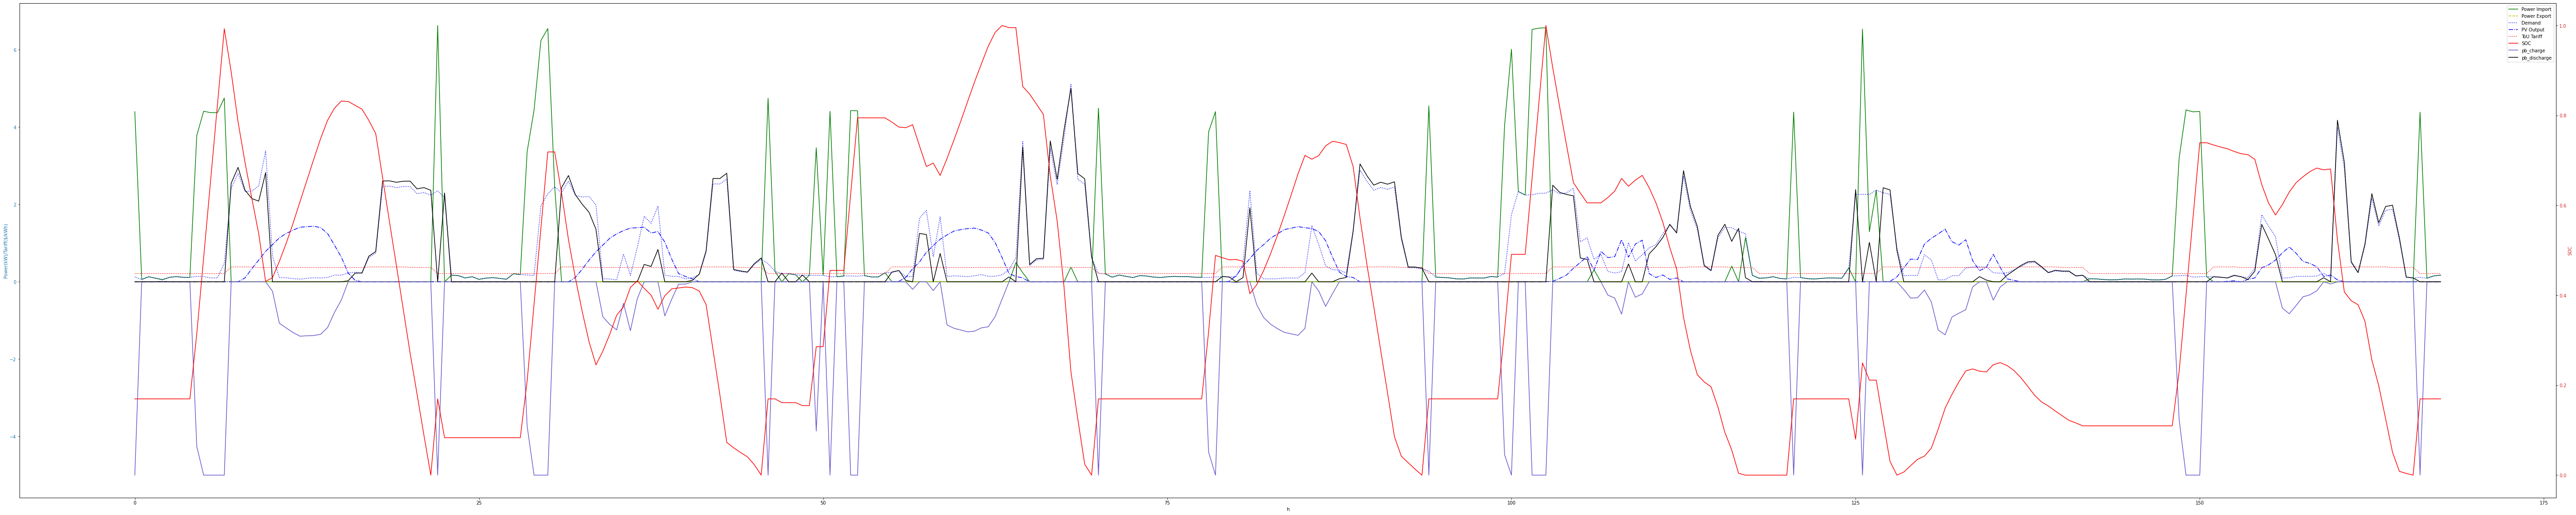

In [67]:
load=[]
GGG=[]
T_tou1=[]
pg_import3,pg_export3,pb_c3,pb_d3,soc3=[],[],[],[],[]
for i in np.arange(14,21,1):
    load.extend(Total_Load_array[i])
    GGG.extend(GG_array[i])
    T_tou1.extend(T_tou)
    pg_import3.extend(pg_import_milp[i])
    pg_export3.extend(pg_export_milp[i])
    pb_c3.extend(pb_c_milp[i])
    pb_d3.extend(pb_d_milp[i])

x = [0.5*i for i in range(48*7)]
y = [0.5*i for i in range(49)]

fig, ax1 = plt.subplots(figsize=(100,20))
color = 'tab:blue'
ax1.set_xlabel('h')
ax1.set_ylabel('Power(kW)/Tariff($/kWh)', color=color)
l1,=ax1.plot(x, np.array(pg_import3), color='g',label='Power Import')
l2,=ax1.plot(x, np.array(pg_export3), '--',color='y',label='Power Export')
l3,=ax1.plot(x, np.array(load),':',color='b',label='Demand')
l4,=ax1.plot(x, np.array(GGG),'-.',color='b',label='PV Output')
l5,=ax1.plot(x, T_tou1,':',color='r',label='ToU Tariff')
l7,=ax1.plot(x, -np.array(pb_c3),color='slateblue',label='pb_charge')
l8,=ax1.plot(x, pb_d3,color='k',label='pb_discharge')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('SOC', color=color)  # we already handled the x-label with ax1
l6,=ax2.plot(x, np.array(soc_milp[1:])/14, 'r',label='SOC')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(handles=[l1,l2,l3,l4,l5,l6,l7,l8],loc=1)
#fig.tight_layout()
plt.show()

In [78]:
load=[]#MILP PP
GGG=[]
T_tou1=[]
pg_import3,pg_export3,pb_c3,pb_d3,soc3=[],[],[],[],[]
for i in np.arange(14,360,1):
    load.extend(Total_Load_array[i])
    GGG.extend(GG_array[i])
    T_tou1.extend(T_tou)
    pg_import3.extend(pg_import_milp[i])
    pg_export3.extend(pg_export_milp[i])
    pb_c3.extend(pb_c_milp[i])
    pb_d3.extend(pb_d_milp[i])
cost,dh,T_fit=0,0.5,0.09
for i in range(len(pg_import3)):
    cost+=pg_import3[i]*T_tou1[i]*dh-pg_export3[i]*T_fit*dh
cost

1912.2763698200522

In [80]:
load=[]
GGG=[]
T_tou1=[]
pg_import4,pg_export4,pb_c4,pb_d4,soc4=[],[],[],[],[]
for i in np.arange(14,360,1):
    T_tou1.extend(T_tou)
    pg_import4.extend(pg_import_milp3[i])
    pg_export4.extend(pg_export_milp3[i])
cost,dh,T_fit=0,0.5,0.09
for i in range(len(pg_import4)):
    cost+=pg_import4[i]*T_tou1[i]*dh-pg_export4[i]*T_fit*dh
cost

2083.212213698412

In [ ]:
def update(predict,ggtemp,loadtemp,user,GG_array,Total_Load_array,d,i,pred,
           pg_import,pg_export,pb_c,pb_d,bat_max,eff_i,eff_c,dh):
############电池单位为千瓦时，其他都是以千瓦为单位####
    soc_before=pred[-1]
    theta=(predict-soc_before)
        
    if(theta>=0):#要充电
        pb_c[d][i]=(theta)/(dh*eff_c)
        pb_d[d][i]=(0)
        if(i==47):
            theta2=GG_array[d+1][0]*eff_i-Total_Load_array[d+1][0]-(theta)/(dh*eff_c)
        else:
            theta2=GG_array[d][i+1]*eff_i-Total_Load_array[d][i+1]-(theta)/(dh*eff_c)#下一时刻实际发电量是否满足
        if(theta2>=0):#发电量够了,卖电
            pg_import[d][i]=0
            pg_export[d][i]=(theta2)#卖出多余的电
        else:#thata3<0，剩余发电量不能满足负载，买电
            pg_import[d][i]=(-theta2)
            pg_export[d][i]=(0)
    else:#要放电
        pb_c[d][i]=(0)
        pb_d[d][i]=(-theta)*eff_c/dh
        if(i==47):
            theta2=GG_array[d+1][0]*eff_i-Total_Load_array[d+1][0]-theta*eff_c/dh
        else:
            theta2=GG_array[d][i+1]*eff_i-Total_Load_array[d][i+1]-theta*eff_c/dh#下一时刻实际发电量是否满足
        if(theta2>=0):#放的电能满足负载
            pg_export[d][i]=(theta2)
            pg_import[d][i]=[0]
        else:
            pg_import[d][i]=(-theta2)
            pg_export[d][i]=(0)
    return pg_import,pg_export,pb_c,pb_d

In [17]:
year=2012
    ###step 1：得到分类结果，给出属于同一类的用户标号
position=[1,3,6,12,14,15,16,18,19,22,23,26,28,31,32,34,38,41,42,43,45,46,47]
    ###step 2：处理该类中MILP、SOC，为了节约时间，将他们先处理保存，之后读取即可
for user in position:
    GG_array,Total_Load_array,pv_size=Read_year(year,user)
    soc,pg_import,pg_export,pb_c,pb_d=MILP_365(Total_Load_array,GG_array,user)
    save(soc,"C:/Users/chenxihui/Desktop/code/project/processed_data/soc-"+str(year)+"-"+str(user)+"-"+".xlsx")
    print(str(user)+"has been done!!")

KeyboardInterrupt: 

In [12]:
year=2012

users=['2','13','14','20','33','35','38','39','56','69','73','74','75'
          ,'82','87','88','101','104','106','109','110','119','124','130'
          ,'137','141','144','152','153','157','161','169','176','184','188'
          ,'189','193','201','202','204','206','207','210','211','212','214'
          ,'218','244','246','253','256','273','276','297']
pv=[]
for i in range(54): 
    GG_array,Total_Load_array,pv_size=Read_year(year,i)
    pv.append(pv_size)

a={}
for i in range(54):
    a[i]= pv[i]
L=a
#L=list(a.items())
#L.sort(key=lambda x:x[1],reverse=False)
for i in range(54):
    if(i in [6,7,33,38,22]):
        L[i]=3
    elif(i in [2,17 ,34 ,18,23,26,43,53 ,45,46,48,3,39,0,32]):
        L[i]=4
    elif(i in [37,15 ,24 ,40 ,42,10,14 ,47 ,52,9 ,16 ,31,35 ,4 ,5,8 ,21,28,44,1]):
        L[i]=5
    elif(i in [41,20,49,25]):
        L[i]=6
    elif(i in [51,13] ):
        L[i]=7
    elif(i in [36,11] ):
        L[i]=8
    elif(i in [27,50] ):
        L[i]=9
    elif(i in [19,12]):
        L[i]=10

In [30]:
L={0: 4,1: 5,2: 4,3: 4,4: 5,5: 5,6: 3,7: 3,8: 5,9: 5,10: 5,11: 8,12: 10,13: 7,14: 5,
 15: 5,16: 5,17: 4,18: 4,19: 10,20: 6,21: 5,22: 3,23: 4,24: 5,25: 6,26: 4,27: 9,28: 5,29: 9.99,
 30: 3.2,31: 5,32: 4,33: 3,34: 4,35: 5,36: 8,37: 5,38: 3,39: 4,40: 5,41: 6,42: 5,43: 4,
 44: 5,45: 4,46: 4,47: 5,48: 4,49: 6,50: 9,51: 7,52: 5,53: 4}

In [25]:
#因为在MILP时，PVsize大小啥的都是变的
year=2012

users=['2','13','14','20','33','35','38','39','56','69','73','74','75'
          ,'82','87','88','101','104','106','109','110','119','124','130'
          ,'137','141','144','152','153','157','161','169','176','184','188'
          ,'189','193','201','202','204','206','207','210','211','212','214'
          ,'218','244','246','253','256','273','276','297']
position=[1,3,6,12,14,15,16,18,19,22,23,26,28,31,32,34,38,41,42,43,45,46,47]
pv=[]
for item in position: 
    GG_array,Total_Load_array,pv_size=Read_year(year,item)
    #soc,pg_import,pg_export,pb_c,pb_d=MILP_365(pv_size,Total_Load_array,GG_array)
    #save(soc,"C:/Users/chenxihui/Desktop/code/project/processed_data/soc"+str(year)+str(i)+".xlsx")
    #print(str(i)+"has been done!")
    #print(pv_size)
    pv.append(pv_size)

2.22
1.57
1.05
8.0
2.0
1.8
2.04
1.5
6.2
1.2
1.5
1.5
2.1
2.04
1.75
1.48
1.05
2.7
1.94
1.5
1.53
1.53
2.0


In [ ]:
#####将数据打乱
x_train, y_train=train_load()

index = [i for i in range(len(x_train))]

np.random.shuffle(index)

x_train= x_train[index]

y_train = y_train[index]
